In [1]:
import os
import numpy as np
from datetime import datetime, tzinfo, timedelta, timezone
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from pathlib import Path
from pandas.plotting import register_matplotlib_converters
import san
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

def read_csvs_and_apply_timedelta(comb_dict):
    modified_dfs = {}
    for source, assets in comb_dict.items():
        modified_dfs[source] = {}
        for asset, timeframes in assets.items():
            modified_dfs[source][asset] = {}
            for timeframe, info in timeframes.items():
                file_path = info['file_path']
                timedelta_hours = info['timedelta']
                
                # Placeholder for loading the actual DataFrame from CSV
                df = pd.read_csv(file_path, index_col=0, parse_dates=True) 
                df.index = df.index + pd.Timedelta(hours=timedelta_hours)

                modified_dfs[source][asset][timeframe] = df
    return modified_dfs

# List to hold all the DataFrames across sources, assets, and timeframes
def merge_dataframes(modified_dfs):
    all_dfs = []
    
    for source in modified_dfs:
        for asset in modified_dfs[source]:
            for timeframe in modified_dfs[source][asset]:
                # Access the DataFrame
                df = modified_dfs[source][asset][timeframe]
                # Append the DataFrame to our list
                all_dfs.append(df)
    
    # Concatenate all DataFrames along the columns using their datetime index for alignment
    merged_df = pd.concat(all_dfs, axis=1, ignore_index=False).sort_index()
    
    return merged_df
    
def timestamp_to_week_cycle(timestamp, milliseconds_in_week=7*24*60*60*1000):
    # Calculate the total number of milliseconds since the beginning of the week (Monday)
    total_milliseconds = ((timestamp.dayofweek * 24 * 60 * 60 * 1000) +
                        (timestamp.hour * 60 * 60 * 1000) +
                        (timestamp.minute * 60 * 1000) +
                        (timestamp.second * 1000) +
                        timestamp.microsecond / 1000) % milliseconds_in_week
    
    # Map the milliseconds to a 2π cycle
    radians = (total_milliseconds / milliseconds_in_week) * 2 * np.pi
    return np.sin(radians), np.cos(radians)

def timestamp_to_weekday_hour(timestamp):
    day = timestamp.weekday()
    hour = timestamp.hour

    return day, hour

In [2]:
san.ApiConfig.api_key = os.getenv('SAN_API_KEY') 
calls_remaining = san.api_calls_remaining()
# should be {'month_remaining': '1200000', 'hour_remaining': '60000', 'minute_remaining': '1200'} on Max Business Plan
print(calls_remaining)

SAVE_FOLDER = './data/dataset'
Path(SAVE_FOLDER).mkdir(parents=True, exist_ok=True)

price_column = 'close_0060_FTM' 

{'month_remaining': '4989', 'hour_remaining': '991', 'minute_remaining': '99'}


In [3]:
# #Download data from Santiment and Binance
# !python scraper_santiment.py --coins "BTC,FTM" --resolutions "1h,24h" --start_time "2020-07-01T00:00:00" --end_time "2024-03-11T00:00:00" --endpoint_file_paths "./data/endpoints_file_path_santiment.json" --save_folder "./data/test/santiment/historical" --mode "historical"
# !python scraper_binance.py --coins "BTC,FTM" --resolutions "1h,1d" --start_time "2020-07-01T00:00:00" --end_time "2024-03-11T00:00:00" --endpoint_file_paths "./data/endpoints_file_path_binance.json" --save_folder "./data/test/binance/historical" --mode "historical"

In [9]:
batch = san.AsyncBatch()
batch.get("bitfinex_perpetual_funding_rate", slug="bitcoin", from_date="2024-05-14T00:00:00", to_date="2025-04-14T00:00:00", resolution="1h") 

In [10]:
batch_pd = batch.execute()

{0:                                   value
datetime                               
2024-05-14 00:00:00+00:00  8.057140e-07
2024-05-15 00:00:00+00:00  8.008330e-07
2024-05-16 00:00:00+00:00  7.912500e-07
2024-05-17 00:00:00+00:00  7.783330e-07
2024-05-18 00:00:00+00:00  8.229170e-07
...                                 ...
2025-04-09 00:00:00+00:00  1.202083e-06
2025-04-10 00:00:00+00:00  1.195000e-06
2025-04-11 00:00:00+00:00  1.207083e-06
2025-04-12 00:00:00+00:00  1.210000e-06
2025-04-13 00:00:00+00:00  1.210000e-06

[335 rows x 1 columns]}


In [13]:
san.get(
  "bitfinex_perpetual_funding_rate",
  slug="bitcoin",
  from_date="2024-05-14T00:00:00",
  to_date="2025-04-14T00:00:00",
  interval="1h"
)

,value
datetime,
2024-05-14 10:00:00+00:00,7.900000e-07
2024-05-14 11:00:00+00:00,8.100000e-07
2024-05-14 12:00:00+00:00,8.100000e-07
2024-05-14 13:00:00+00:00,8.100000e-07
2024-05-14 14:00:00+00:00,8.100000e-07
...,...
2025-04-13 19:00:00+00:00,1.210000e-06
2025-04-13 20:00:00+00:00,1.210000e-06
2025-04-13 21:00:00+00:00,1.210000e-06


In [13]:
#Download data from Santiment and Binance
!python scraper_santiment.py --coins "BTC,FTM" --resolutions "1h,24h" --start_time "2024-05-14T00:00:00" --end_time "2025-04-14T00:00:00" --endpoint_file_paths "./data/endpoints_file_path_santiment.json" --save_folder "./data/test/santiment/historical" --mode "historical"

1642.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Traceback (most recent call last):
  File "/home/jschaust/python/deep-reinforcement-learning-for-crypto-trading/scraper_santiment.py", line 173, in <module>
    main(args)
  File "/home/jschaust/python/deep-reinforcement-learning-for-crypto-trading/scraper_santiment.py", line 152, in main
    scraper.scrape()
  File "/home/jschaust/python/deep-reinforcement-learning-for-crypto-trading/scraper_santiment.py", line 83, in scrape
    batch_pd = batch.execute(max_workers=8)
  File "/home/jschaust/anaconda3/envs/sane_ai_4/lib/python3.9/site-packages/san/async_batch.py", line 42, in execute
    for (idx, response) in executor.map(task, enumerate(self.queries)):
  File "/home/jschaust/anaconda3/envs/sane_ai_4/lib/python3.9/concurrent/futures/_base.py", line 609, in result_iterator
    yield fs.pop().result()
  File "/home/jschaust/anaconda3/envs/sane_ai_4/lib/python3.9/concurrent/futures/_base.py", line 446, in result
    return self.__get_result()
  File "/home/jschaust/anaconda3/envs/sane_ai

In [ ]:
!python scraper_binance.py --coins "BTC,FTM" --resolutions "1h,1d" --start_time "2024-05-14T00:00:00" --end_time "2025-04-14T00:00:00" --endpoint_file_paths "./data/endpoints_file_path_binance.json" --save_folder "./data/test/binance/historical" --mode "historical"

In [ ]:
# Commands for live data
# !python scraper_binance.py --coins "BTC,ETH,FTM" --resolutions "1h,1d" --endpoint_file_paths "./data/endpoints_file_path_binance.json" --save_folder "./data/test/binance/live" --mode "live"
# !python scraper_bybit.py --coins "BTC,FTM" --resolutions "1h,1d" --endpoint_file_paths "./data/endpoints_file_path_bybit.json" --save_folder "./data/test/bybit/live" --mode "live"
# !python scraper_santiment.py --coins "BTC,ETH,FTM" --resolutions "1h,24h" --endpoint_file_paths "./data/endpoints_file_path_santiment.json" --save_folder "./data/test/santiment/live" --mode "live"
# !python scraper_glassnode.py --coins "BTC,ETH" --resolutions "1h,24h" --endpoint_file_paths "./data/endpoints_file_path_glassnode.json" --save_folder "./data/test/glassnode/live" --mode "live"

In [5]:
# Uncomment comb_dict keys (platforms, coins, timeframes) used for dataset creation

comb_dict = {
    "binance": {
        "BTC": {
            "1h": {
                "file_path": "./data/test/binance/historical/scraped_binance_BTC_1h_2025-05-11_00:00:00.csv",
                "timedelta": 1
            },
            "24h": {
                "file_path": "./data/test/binance/historical/scraped_binance_BTC_1d_2025-05-11_00:00:00.csv",
                "timedelta": 24
            }
        },
        # "ETH": {
        #     "1h": {
        #         "file_path": "./data/test/binance/historical/scraped_binance_ETH_1h_2024-03-11_00:00:00.csv",
        #         "timedelta": 1
        #     },
        #     "24h": {
        #         "file_path": "./data/test/binance/historical/scraped_binance_ETH_1d_2024-03-11_00:00:00.csv",
        #         "timedelta": 24
        #     }
        # },
        "FTM": {
            "1h": {
                "file_path": "./data/test/binance/historical/scraped_binance_FTM_1h_2025-05-11_00:00:00.csv",
                "timedelta": 1
            },
            "24h": {
                "file_path": "./data/test/binance/historical/scraped_binance_FTM_1d_2025-05-11_00:00:00.csv",
                "timedelta": 24
            }
        },
        # "BAT": {
        #     "1h": {
        #         "file_path": "./data/test/binance/historical/scraped_binance_BAT_1h_2024-03-11_00:00:00.csv",
        #         "timedelta": 1
        #     },
        #     "24h": {
        #         "file_path": "./data/test/binance/historical/scraped_binance_BAT_1d_2024-03-11_00:00:00.csv",
        #         "timedelta": 24
        #     }
        # },
    },

    # "bybit": {
    #     "BTC": {
    #         "1h": {
    #             "file_path": "./data/test/bybit/historical/scraped_bybit_BTC_1h_2024-03-11_00:00:00.csv",
    #             "timedelta": 1
    #         },
    #         "24h": {
    #             "file_path": "./data/test/bybit/historical/scraped_bybit_BTC_1d_2024-03-11_00:00:00.csv",
    #             "timedelta": 24
    #         }
    #     },
    #     "ETH": {
    #         "1h": {
    #             "file_path": "./data/test/bybit/historical/scraped_bybit_ETH_1h_2024-03-11_00:00:00.csv",
    #             "timedelta": 1
    #         },
    #         "24h": {
    #             "file_path": "./data/test/bybit/historical/scraped_bybit_ETH_1d_2024-03-11_00:00:00.csv",
    #             "timedelta": 24
    #         }
    #     },
    #     "FTM": {
    #         "1h": {
    #             "file_path": "./data/test/bybit/historical/scraped_bybit_FTM_1h_2024-03-11_00:00:00.csv",
    #             "timedelta": 1
    #         },
    #         "24h": {
    #             "file_path": "./data/test/bybit/historical/scraped_bybit_FTM_1d_2024-03-11_00:00:00.csv",
    #             "timedelta": 24
    #         }
    #     },
    # },

    # "glassnode": {
    #     "BTC": {
    #         "1h": {
    #             "file_path": "./data/test/glassnode/historical/scraped_glassnode_BTC_1h_2024-03-11_00:00:00.csv",
    #             "timedelta": 1+1
    #         },
    #         "24h": {
    #             "file_path": "./data/test/glassnode/historical/scraped_glassnode_BTC_24h_2024-03-11_00:00:00.csv",
    #             "timedelta": 24+1
    #         }
    #     },
    #     "ETH": {
    #         "1h": {
    #             "file_path": "./data/test/glassnode/historical/scraped_glassnode_ETH_1h_2024-03-11_00:00:00.csv",
    #             "timedelta": 1+1
    #         },
    #         "24h": {
    #             "file_path": "./data/test/glassnode/historical/scraped_glassnode_ETH_24h_2024-03-11_00:00:00.csv",
    #             "timedelta": 24+1
    #         }
    #     },
    # },

    "santiment": {
        "BTC": {
            "1h": {
                "file_path": "./data/test/santiment/historical/scraped_santiment_BTC_1h_2025-05-11_00:00:00.csv",
                "timedelta": 1+1
            },
            "24h": {
                "file_path": "./data/test/santiment/historical/scraped_santiment_BTC_24h_2025-05-11_00:00:00.csv",
                "timedelta": 24+4
            }
        },
        # "ETH": {
        #     "1h": {
        #         "file_path": "./data/test/santiment/historical/scraped_santiment_ETH_1h_2024-03-11_00:00:00.csv",
        #         "timedelta": 1+1
        #     },
        #     "24h": {
        #         "file_path": "./data/test/santiment/historical/scraped_santiment_ETH_24h_2024-03-11_00:00:00.csv",
        #         "timedelta": 24+4
        #     }
        # },
        "FTM": {
            "1h": {
                "file_path": "./data/test/santiment/historical/scraped_santiment_FTM_1h_2025-05-11_00:00:00.csv",
                "timedelta": 1+1
            },
            "24h": {
                "file_path": "./data/test/santiment/historical/scraped_santiment_FTM_24h_2025-05-11_00:00:00.csv",
                "timedelta": 24+4
            }
        },

    #    "BAT": {
    #         "1h": {
    #             "file_path": "./data/test/santiment/historical/scraped_santiment_BAT_1h_2024-03-11_00:00:00.csv",
    #             "timedelta": 1+1
    #         },
    #         "24h": {
    #             "file_path": "./data/test/santiment/historical/scraped_santiment_BAT_24h_2024-03-11_00:00:00.csv",
    #             "timedelta": 24+4
    #         }
    #     },

    #     "USDT": {
    #         "1h": {
    #             "file_path": "./data/test/santiment/historical/scraped_santiment_USDT_1h_2024-03-11_00:00:00.csv",
    #             "timedelta": 1+1
    #         },
    #         "24h": {
    #             "file_path": "./data/test/santiment/historical/scraped_santiment_USDT_24h_2024-03-11_00:00:00.csv",
    #             "timedelta": 24+4
    #         }
    #     },
    },
}

In [6]:
modified_dfs = read_csvs_and_apply_timedelta(comb_dict)
merged_df = merge_dataframes(modified_dfs)

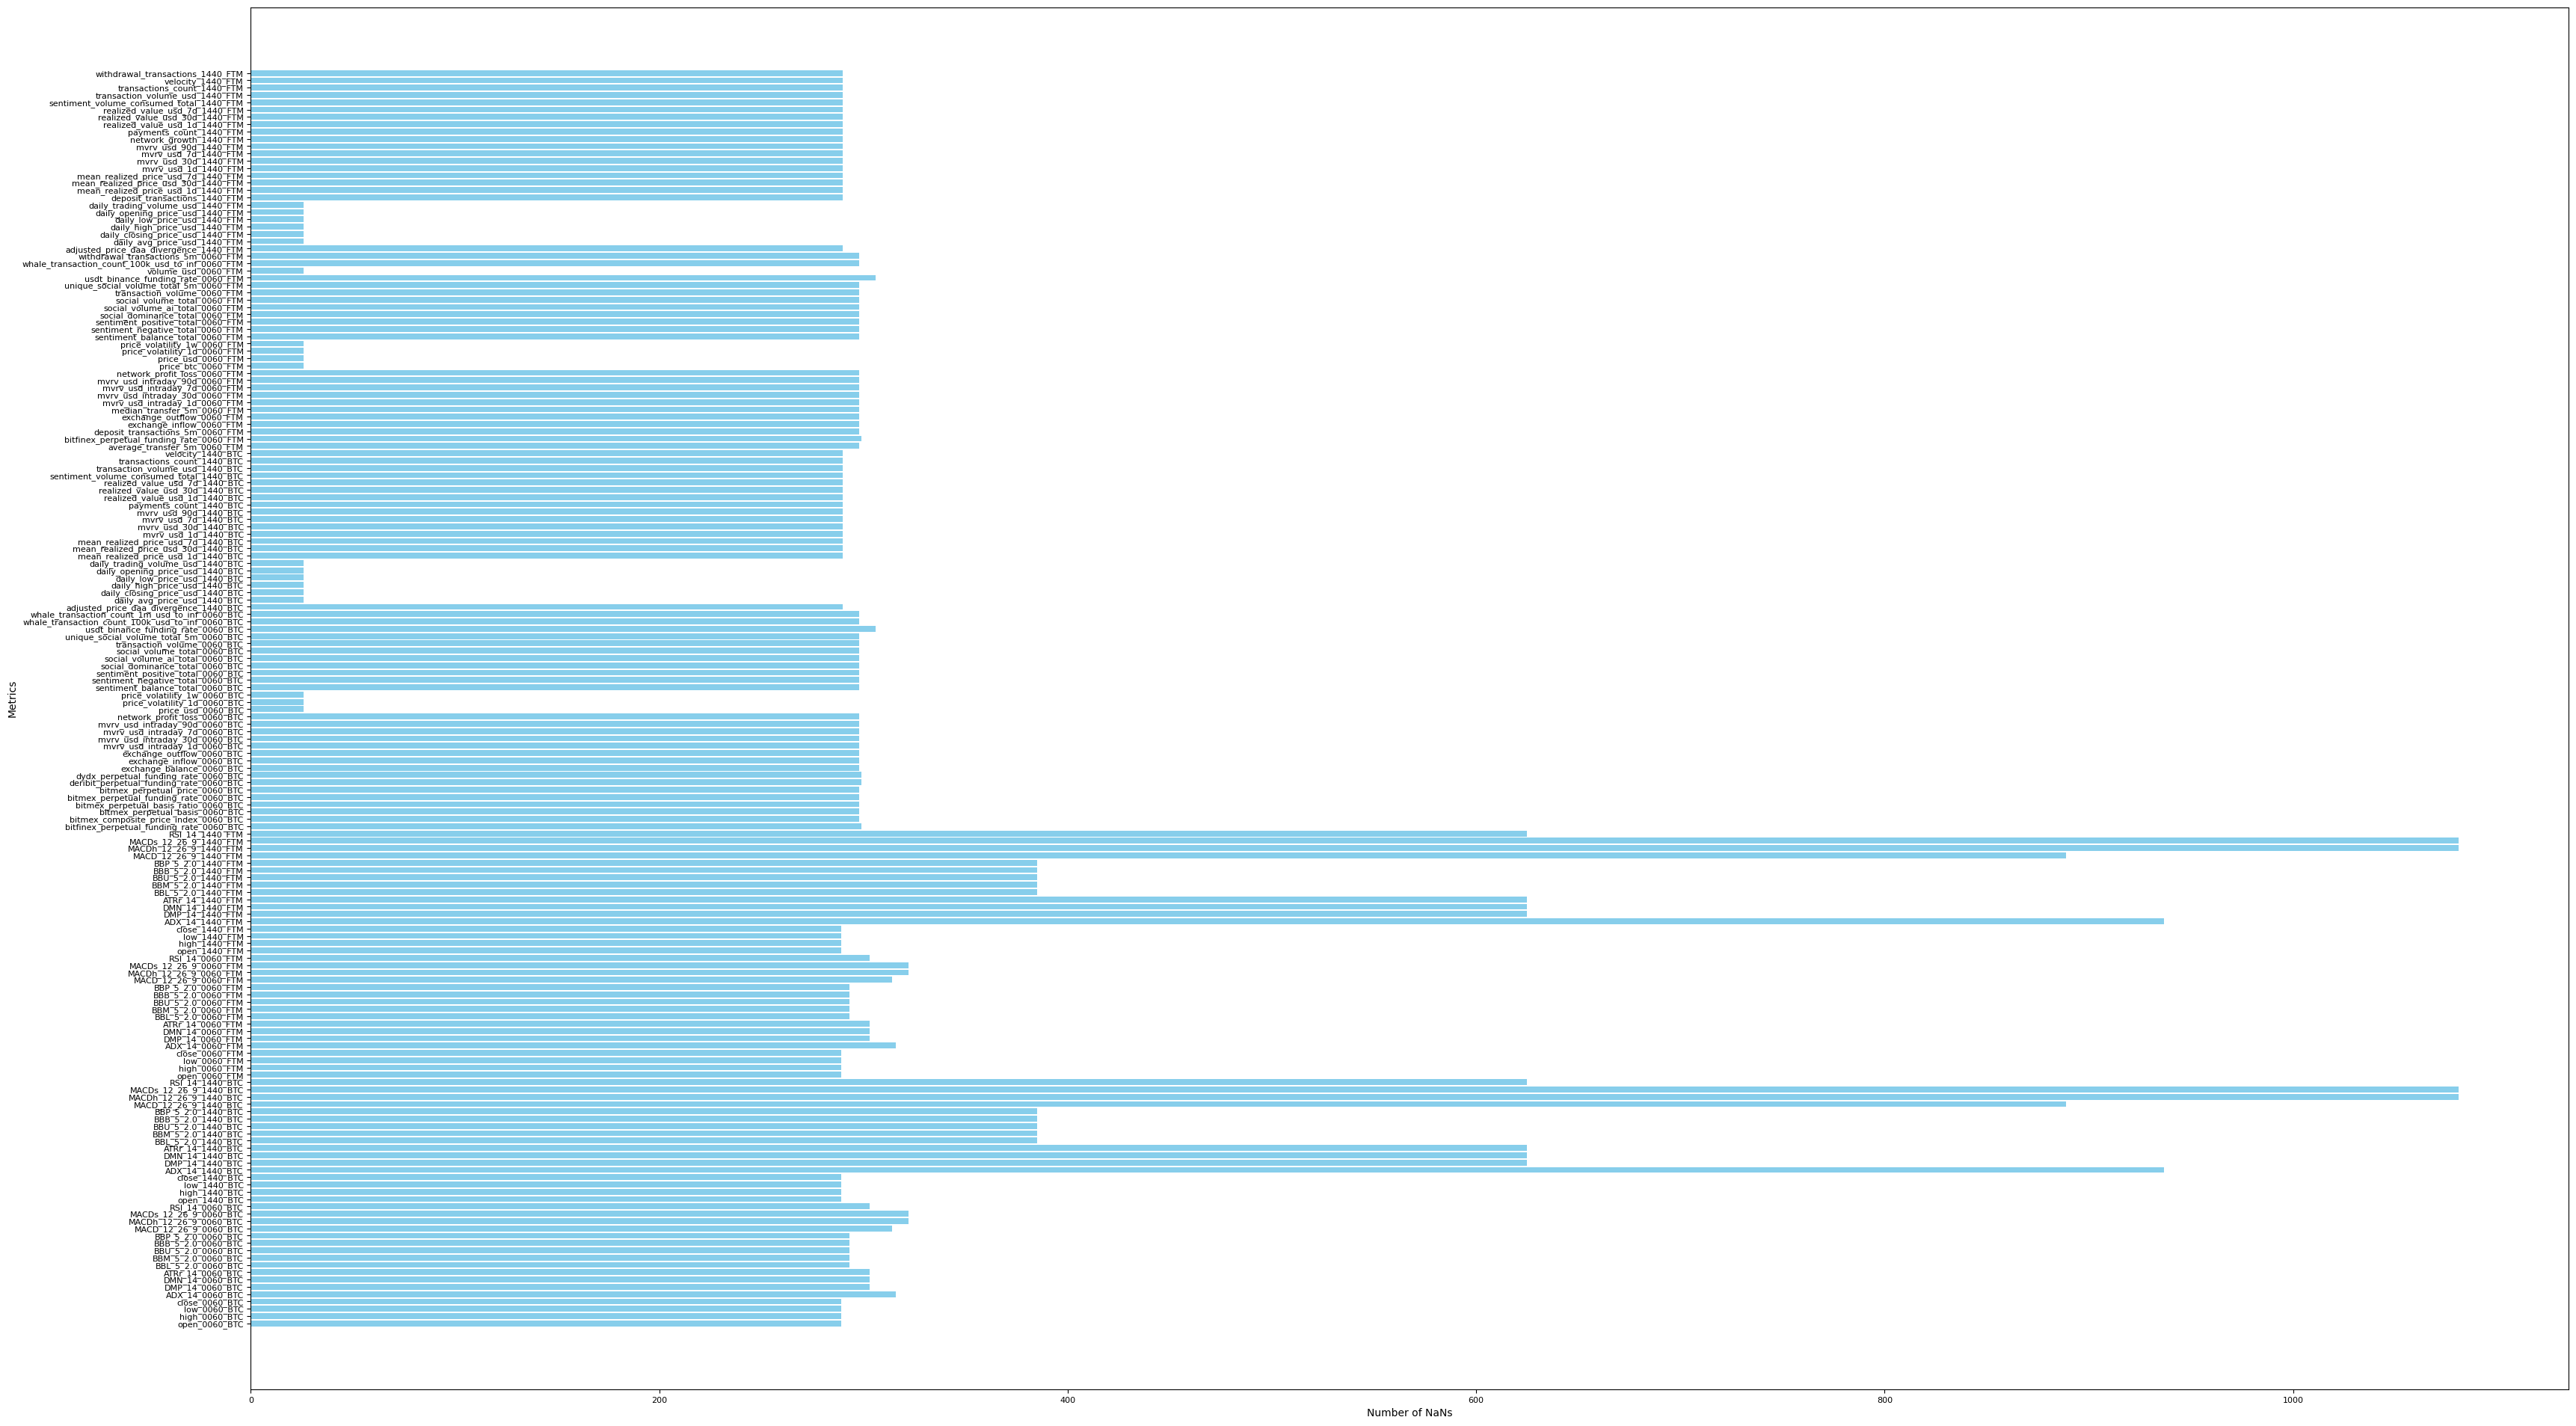

In [7]:
# Detect number of NaNs at the beginning of each metric (this metric hasn't been recorded/calculated)

nan_counts = merged_df.isna().sum()
nan_counts_df = pd.DataFrame(nan_counts)

# Reset index to get column names into a column itself
nan_counts_df.reset_index(inplace=True)
nan_counts_df.columns = ['Metric', 'Value']

# Plotting
fig, ax = plt.subplots(figsize=(40, 24))
ax.barh(nan_counts_df['Metric'], nan_counts_df['Value'], color='skyblue')

# Setting labels and title
ax.set_xlabel('Number of NaNs')
ax.set_ylabel('Metrics')

ax.tick_params(axis='both', which='major', labelsize=8)

plt.show()

In [8]:
# Detect rows without any NaN values
rows_without_nan = merged_df.dropna().index

# # Index of the first non-NaN row
# first_non_nan_index = rows_without_nan[0] if not rows_without_nan.empty else None

# Choose first index manually
first_non_nan_index = merged_df.index[3000]
print("datetime of the first index:", first_non_nan_index)

# Index of the last non-NaN row
last_non_nan_index = rows_without_nan[-1] if not rows_without_nan.empty else None
print("datetime of the last index:", last_non_nan_index)

# The actual slicing
merged_df = merged_df.loc[first_non_nan_index:last_non_nan_index]

merged_df = merged_df.fillna(0.)

datetime of the first index: 2024-09-03 02:00:00
datetime of the last index: 2025-05-11 01:00:00


In [9]:
# Add columns for time encoding

# merged_df['week_sin'], merged_df['week_cos'] = zip(*merged_df.index.map(timestamp_to_week_cycle))
merged_df['weekday'], merged_df['hour'] = zip(*merged_df.index.map(timestamp_to_weekday_hour))

cols = merged_df.columns.tolist()  # Get the list of all columns
reordered_cols = cols[-2:] + cols[:-2]  # Last two columns to the front
merged_df = merged_df[reordered_cols]  # Apply new column order

merged_df.to_csv(os.path.join(SAVE_FOLDER, "merged_df.csv"))

In [10]:
# Save final dataset as .npy files

close_price_index = merged_df.columns.get_loc(price_column)
price_array = np.array(merged_df.iloc[:, close_price_index])
price_array = np.expand_dims(price_array.astype(np.float32), axis=1)

tech_array = np.array(merged_df).astype(np.float32)

print("price_array shape:", price_array.shape)
print("tech_array shape:", tech_array.shape)

np.save(os.path.join(SAVE_FOLDER, "price_outfile.npy"), price_array)
np.save(os.path.join(SAVE_FOLDER, "metrics_outfile.npy"), tech_array)

price_array shape: (6000, 1)
tech_array shape: (6000, 174)


In [11]:
merged_df[price_column]

2024-09-03 02:00:00    0.4300
2024-09-03 03:00:00    0.4297
2024-09-03 04:00:00    0.4259
2024-09-03 05:00:00    0.4248
2024-09-03 06:00:00    0.4254
                        ...  
2025-05-10 21:00:00    0.7702
2025-05-10 22:00:00    0.7702
2025-05-10 23:00:00    0.7702
2025-05-11 00:00:00    0.7702
2025-05-11 01:00:00    0.7702
Freq: H, Name: close_0060_FTM, Length: 6000, dtype: float64

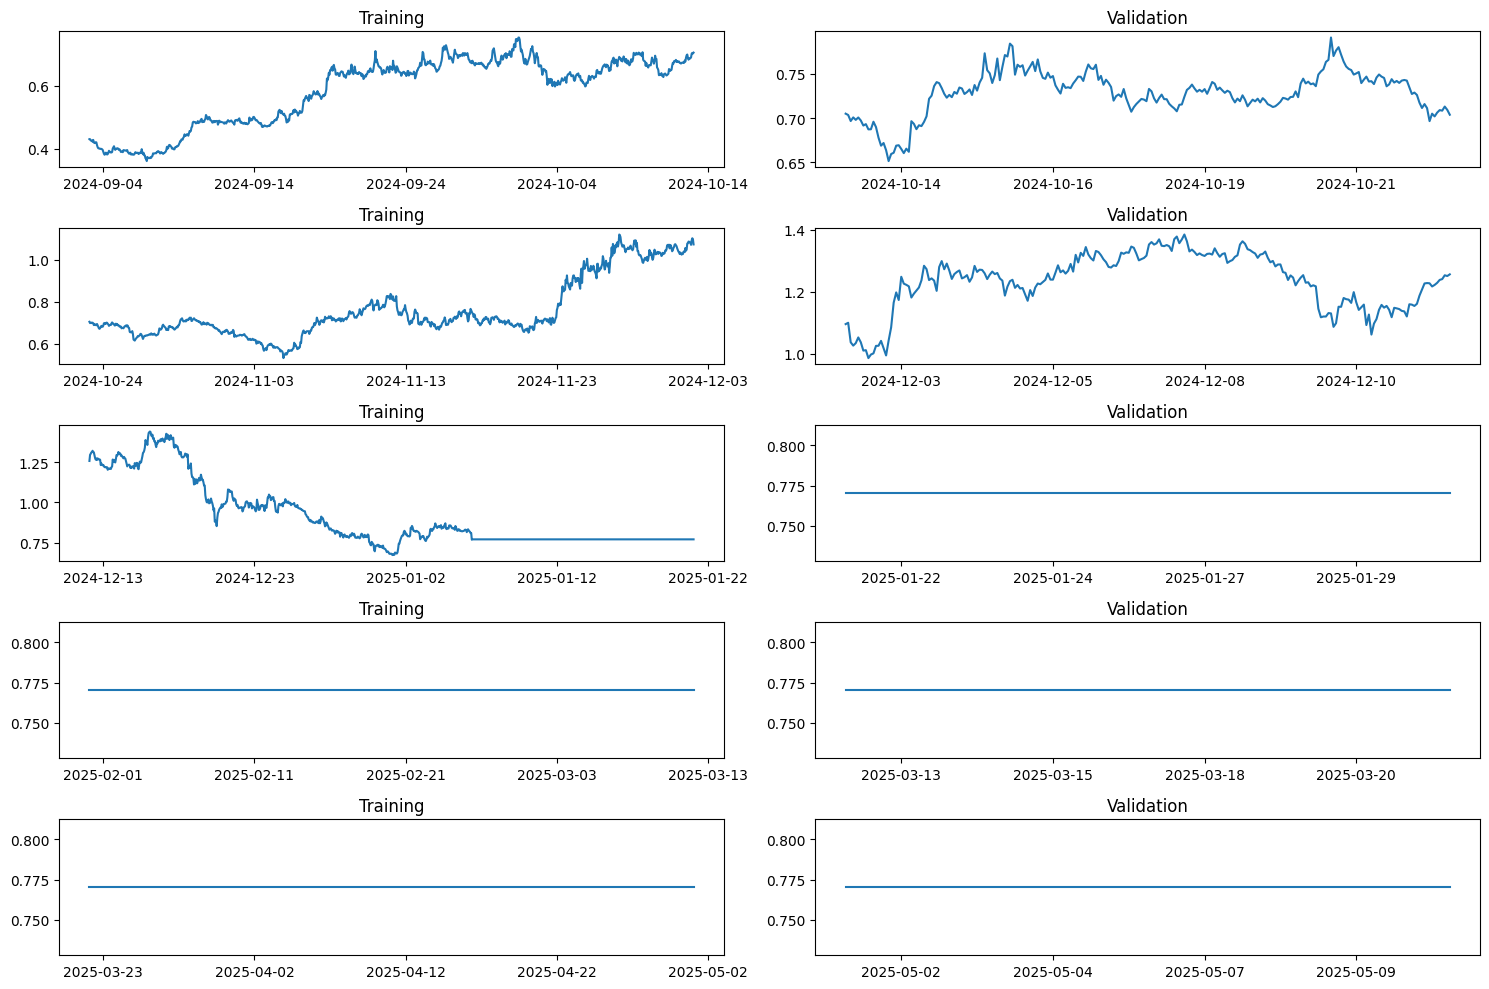

In [12]:
# Visualize training and validation intervals
register_matplotlib_converters()

# choose intervals for training and validation
# training/validation split is 80/20
data_frames = [
    merged_df.iloc[0:960, [close_price_index]], merged_df.iloc[960:1200, [close_price_index]],
    merged_df.iloc[1200:2160, [close_price_index]], merged_df.iloc[2160:2400, [close_price_index]],
    merged_df.iloc[2400:3360, [close_price_index]], merged_df.iloc[3360:3600, [close_price_index]],
    merged_df.iloc[3600:4560, [close_price_index]], merged_df.iloc[4560:4800, [close_price_index]],
    merged_df.iloc[4800:5760, [close_price_index]], merged_df.iloc[5760:6000, [close_price_index]]
]


fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 10))
axs = axs.flatten()  # Flatten to make it easier to iterate

# Plot each DataFrame in its subplot
for i, (ax, df) in enumerate(zip(axs, data_frames)):
    # ax.plot(df.index, df['Value'])
    ax.plot(df.index, df[price_column])

    if i % 2 == 0:
        ax.set_title('Training')
    else:
        ax.set_title('Validation')

    # Optional: Format the x-axis with specific date formatting
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Limit number of ticks

# Automatically adjust plot parameters to give room and prevent overlap
plt.tight_layout()
plt.show()

In [13]:
data_frames[4]

,close_0060_FTM
2024-12-12 02:00:00,1.2583
2024-12-12 03:00:00,1.2962
2024-12-12 04:00:00,1.3029
2024-12-12 05:00:00,1.3110
2024-12-12 06:00:00,1.3136
...,...
2025-01-20 21:00:00,0.7702
2025-01-20 22:00:00,0.7702
2025-01-20 23:00:00,0.7702
2025-01-21 00:00:00,0.7702
